## **Load the Preprocessed Data**

First, you need to import the required libraries and load the `preprocessed_data.csv` file that you saved earlier.

In [1]:
import pandas as pd
import numpy as np

# Load the preprocessed data
new_data = pd.read_csv(r"E:/Random Python Scripts/CICIDS/CICIDS2017/preprocessed_data.csv")

## **Creating a balanced dataset for Multi-Class Classification**

The following dataset is highly imbalanced, we took the help of **SMOTE (Synthetic Minority Over-sampling Technique)** to upsample the minority classes while creating a balanced dataset for multi-class classification. This helped us in creating an overall balanced dataset to feed the classification models.

In [2]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

Ensures a more balanced dataset by controlling the number of samples per class.

In [3]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

Attack Type
BENIGN         5000
DoS            5000
DDoS           5000
Port Scan      5000
Brute Force    5000
Web Attack     2143
Bot            1953
Name: count, dtype: int64

Combines the upsampled features and labels into a new DataFrame (`blnc_data`).

In [4]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
DoS            5000
Port Scan      5000
BENIGN         5000
Bot            5000
Web Attack     5000
DDoS           5000
Brute Force    5000
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

# **MLP**

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for MLPClassifier
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Get label names for classification report
label_names = label_encoder.classes_

In [8]:
# Initialize the MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
    activation='logistic',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter=2000,
    random_state=0
)

In [9]:
# Train the model
print('[MLP] Training...')
mlp_model.fit(X_train, y_train_encoded)
print('[MLP] Training completed!')

[MLP] Training...
[MLP] Training completed!


In [10]:
import joblib

# Save the trained model
joblib.dump(mlp_model, 'mlp_model.pkl')
print("MLP model saved as 'mlp_model.pkl'")

MLP model saved as 'mlp_model.pkl'


In [11]:
'''
# Load the saved model
loaded_model = joblib.load('mlp_model.pkl')
print("MLP model loaded successfully!")

# Predict using the loaded model
loaded_y_pred = loaded_model.predict(X_test)
'''

'\n# Load the saved model\nloaded_model = joblib.load(\'mlp_model.pkl\')\nprint("MLP model loaded successfully!")\n\n# Predict using the loaded model\nloaded_y_pred = loaded_model.predict(X_test)\n'

# **Performance Evaluation**

In [12]:
# Predict on the test set
y_pred = mlp_model.predict(X_test)

Accuracy: 0.9757
Confusion Matrix:
[[1120   43    9   19   39   18   11]
 [   8 1262    0    0    0    0    0]
 [   3    0 1194    0    4    0   24]
 [   0    0    0 1234    2    0    0]
 [  11    0    1    0 1252    1    1]
 [   0    1    0    0    1 1268    1]
 [   3    0    0    0   13    0 1207]]


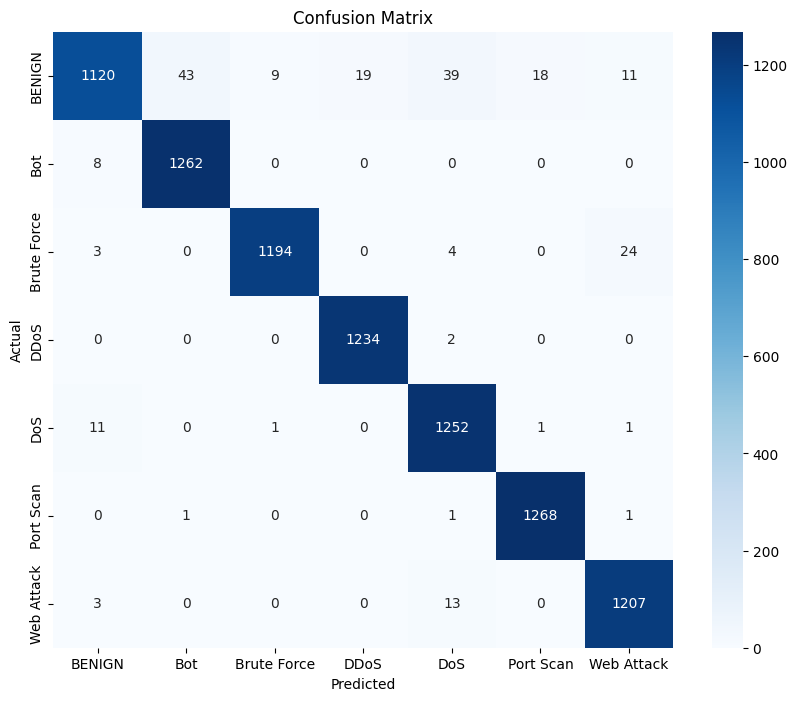

In [13]:
# Calculate Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Generate Classification Report
print('Classification Report:')
report = classification_report(y_test_encoded, y_pred, target_names=label_names)
print(report)

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.98      0.89      0.93      1259
         Bot       0.97      0.99      0.98      1270
 Brute Force       0.99      0.97      0.98      1225
        DDoS       0.98      1.00      0.99      1236
         DoS       0.95      0.99      0.97      1266
   Port Scan       0.99      1.00      0.99      1271
  Web Attack       0.97      0.99      0.98      1223

    accuracy                           0.98      8750
   macro avg       0.98      0.98      0.98      8750
weighted avg       0.98      0.98      0.98      8750

